# PREPROCESSING DATASET PER ANALISI OPEN QUESTION

1. [**Pulizia dei tweet**](#pulizia) dal dataset originario e [**analisi linguistiche**](#analisi_ling) di base utilizzando la libreria **nltk**
2. [**Creazione di un nuovo dataset**](#df_coms) in cui a ciascun utente e tweet scritto assegno una comunità (individuate con l'algoritmo di CD *Louvain* e *K-cliques*, gli algoritmi rispettivamente migliori e peggiori nell'identificazione delle comunitò nella nostra rete)

In [7]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re # regual expression 
import spacy
import string


from textblob import TextBlob
from wordcloud import WordCloud
from nltk import *
from nltk.corpus import stopwords 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

nltk.download('stopwords')
stopw = stopwords.words('english') 
stopw2 = stopwords.words('english') 
stopw.extend(['jd', 'get', 'like', 'know', 'use', 'ah', 'one', 'say', 'look', 'even', 'said', 'would'])
stopw2.extend(['amber', 'heard', 'johnny', 'depp', 'camille', 'elaine'])
Word = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aliis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Pulizia tweet e analisi linguistiche 
1. Rimozione dei **tweet duplicati** dal dataset originale (composto dal risultato dello scraping iniziale)
2. Rimozione degli **elementi superflui** (links, tags a utenti, hashtags, punteggiatura, doppi spazi, maiuscole, link a contenuti come foto, audio, video) all'analisi con l'utilizzo delle re
3. analisi linguistiche: tokenizzazione, lemmtizzazione e analisi delle parole più frequenti (freqDist) utilizzando la libreria **NLTK**

In [8]:
df = pd.read_csv('../data_collection/data/df_finale_aggiornato.csv')
del df['Unnamed: 0']
df.shape

(271352, 12)

### Pulizia Tweet  <a id = 'pulizia'> </a>

In [9]:
import emoji
punteggiatura = '!"$%&\'()*+,-./·:;’“”<=>?[\\]^_`{|}~•@'  #stringa di elementi di punteggiatura che verrranno eliminati dai tweet

# funzione che prende in input una stringa (il tweet) e rimuove gli elementi superflui 
def pulizia_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)   # rimozione dei link http 
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # rimozione dei link bitly 
    tweet = tweet.strip('[link]')   # rimozione dei link: [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet) #rimozione dei link che rimandano a foto
    
    tweet = re.sub('@', '', tweet) #rimozione delle menzioni ad altri users (simbolo @)
    tweet = re.sub('[' + punteggiatura + ']+', ' ', tweet)  # rimozione puteggiatura
    tweet = re.sub('\s+', ' ', tweet)  # rimozione doppi spazi
    tweet = re.sub('([0-9]+)', '', tweet)  # rimozione numeri    
    tweet = re.sub(r'#\S+', ' ', tweet) # rimozione hashtags (simbolo #)
    tweet = re.sub('amp', ' ', tweet) # rimozione simbolo '&'    
    tweet = re.sub('VIDEO:', '', tweet)  # rimuove la scritta 'VIDEO' dall'inizio del tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    tweet = tweet.lower()
    
    return tweet


import pandas as pd
import re
import gensim
from nltk.stem import WordNetLemmatizer

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@ー'         # define a string of punctuation symbols

def pulizia_hasht(hashtag):
    hashtag = re.sub('[' + punctuation + ']+', ' ', hashtag)  # strip punctuation
    hashtag = re.sub('\s+', ' ', hashtag)  # remove double spacing
    hashtag = re.sub('([0-9]+)', '', hashtag)  # remove numbers
    hashtag = re.sub('#', '', hashtag)  # remove numbers
    
    return hashtag


In [10]:
# pulisco i tweet applicando la funzione definita sopra
df['tweet'] = [pulizia_tweet(tweet) for tweet in df.tweet]

In [11]:
# eliminazione delle stopwords
df['tweet'] = df['tweet'].str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stopw))

In [12]:
#lemmazzazione dei tweet: riporto ogni singola parola alla sua forma originaria (lemma)
df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

In [13]:
df['tweet'] #risultato della pulizia

0         hi non deppvsheard follower going long week pr...
1         listening elaine bredehoft excellent opening s...
2                  decide sleep trial sister give testimony
3         cathyrusson lawcrimenetwork case johnny drug w...
4         watching trial see getting fixated similar way...
                                ...                        
271347    bucksexton support red flag hearing ex parte e...
271348    autumnonvenus recently watched youtube video s...
271349    jesselynradack go trial better televised day e...
271350    time taranaburke wait watch depp heard trial e...
271351    last sentence regarding ridiculous gender bias...
Name: tweet, Length: 271352, dtype: object

---

### Analisi linguistiche base dei tweet (n frasi, parole, lettere ecc.) con NLTK  <a id = 'analisi_ling'> </a>

1. **Tokenizzo i tweet**

In [14]:
df['token'] = df["tweet"].astype(str).apply(word_tokenize)

In [15]:
df['token'] 

0         [hi, non, deppvsheard, follower, going, long, ...
1         [listening, elaine, bredehoft, excellent, open...
2           [decide, sleep, trial, sister, give, testimony]
3         [cathyrusson, lawcrimenetwork, case, johnny, d...
4         [watching, trial, see, getting, fixated, simil...
                                ...                        
271347    [bucksexton, support, red, flag, hearing, ex, ...
271348    [autumnonvenus, recently, watched, youtube, vi...
271349    [jesselynradack, go, trial, better, televised,...
271350    [time, taranaburke, wait, watch, depp, heard, ...
271351    [last, sentence, regarding, ridiculous, gender...
Name: token, Length: 271352, dtype: object

Stampo il numero di frasi, lettere. parole uniche e media delle parole contenute nei tweet e con un **pairplot** vedo la correlaizone tra i risultati appena ottenuti, che salvo in un df porvvisorio chiamato *df_linguistico*

In [16]:
df['n_frasi'] = df["tweet"].apply(lambda x: len(re.findall("\n",str(x)))+1)
df['n_parole_uniche'] = df["tweet"].apply(lambda x: len(set(str(x).split())))
df['n_lettere '] = df["tweet"].apply(lambda x: len(str(x)))
df["n_media_parole"] = df["tweet"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

C:\Users\aliis\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


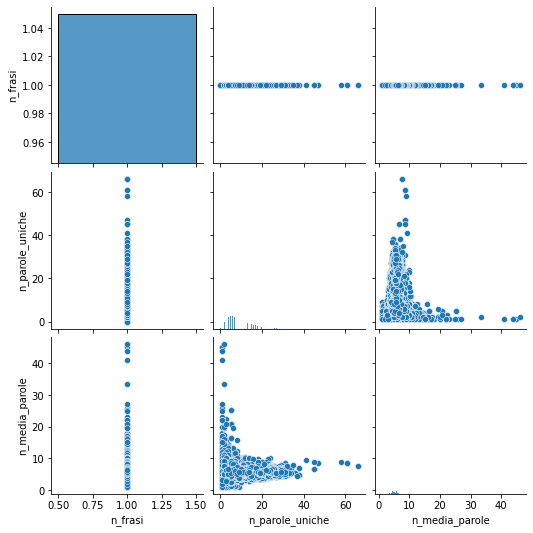

In [17]:
df_linguistico = df[['n_frasi','n_parole_uniche','n_media_parole']]
sns.pairplot(df_linguistico,palette="husl")
del df_linguistico

#### Analisi dei token più frequenti

In [18]:
tok = ''.join(df['tweet'].astype(str)).split()
tok

['hi',
 'non',
 'deppvsheard',
 'follower',
 'going',
 'long',
 'week',
 'pretty',
 'sure',
 'many',
 'going',
 'leave',
 'always',
 'mute',
 '😉😅',
 'hope',
 'everyone',
 'okay',
 'xlistening',
 'elaine',
 'bredehoft',
 'excellent',
 'opening',
 'statement',
 'bredehoft',
 'tell',
 'jury',
 'depp',
 'took',
 'tablet',
 'ecstasy',
 'engaged',
 'violent',
 'assault',
 'wife',
 'period',
 'day',
 'depp',
 'listens',
 'disgusted',
 'guy',
 'sound',
 'awful',
 'facedecide',
 'sleep',
 'trial',
 'sister',
 'give',
 'testimonycathyrusson',
 'lawcrimenetwork',
 'case',
 'johnny',
 'drug',
 'wine',
 'trouble',
 'fake',
 'injury',
 'inconsistent',
 'storywatching',
 'trial',
 'see',
 'getting',
 'fixated',
 'similar',
 'way',
 'got',
 'obsessedcareful',
 'saying',
 'word',
 'honestly',
 'derivation',
 'word',
 'honest',
 'answering',
 'question',
 'come',
 'across',
 'truthful',
 'trying',
 'convince',
 'courttv',
 'courttvuklol',
 'judge',
 'much',
 'dumb',
 'questioning',
 'depp',
 'sister',
 

In [19]:
freq_w = ['amber', 'johnny', 'camille', 'elaine'] 
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@' 

def trova_parola_freq(x):
    list_w = x.split(' ')
    out_data = []
    for word in list_w:
        word = word.lower()
        if word.strip(punctuation) in freq_w:
            return word.strip(punctuation)
        else:
            pass
        
df['word_f'] = df['tweet'].apply(trova_parola_freq) 
df.word_f.value_counts()

amber      45980
johnny     22352
elaine     12196
camille     9960
Name: word_f, dtype: int64

In [20]:
freqdist = FreqDist(tok).most_common(10)
freqdistPlot = pd.Series(dict(freqdist))
freqdistPlot

heard      42817
amber      41469
depp       32789
johnny     25305
trial      18674
witness    13156
time       12010
people      9260
team        8987
see         8374
dtype: int64

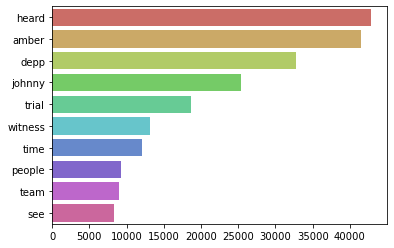

In [21]:
sns.barplot(x=freqdistPlot.values, y=freqdistPlot.index, palette = 'hls')
plt.savefig("plots/Preprocessingtok_freq.png")

(-0.5, 999.5, 499.5, -0.5)

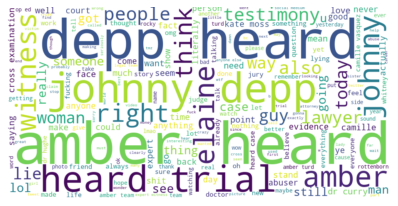

In [22]:
#stopwords = set(stopwords.words('english'))  
tweet_df = df
words = ' '.join([word for word in tweet_df['tweet'].astype(str)])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=150, background_color = 'white', colormap='viridis', stopwords = stopw).generate(words)


plt.imshow(word_cloud, interpolation='bilinear')
plt.savefig('plots/Preprocessingwordcloud_parole_tot.jpg')
plt.tight_layout()
plt.axis('off')

Stessa analisi, ma rimuovendo i nomi  'Amber Heard', 'Johnny Depp', 'Eleaine' e 'Camille'

(-0.5, 999.5, 499.5, -0.5)

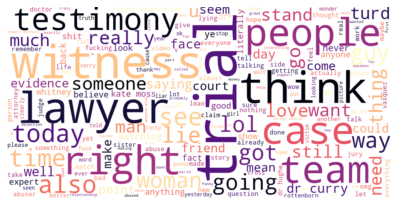

In [23]:
stopw2 = stopwords.words('english') 
stopw2.extend(['amber', 'heard', 'johnny', 'depp', 'camille', 'elaine'])

tweet_df = df
words = ' '.join([word for word in tweet_df['tweet'].astype(str)])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=150, background_color = 'white', colormap='magma', stopwords = stopw2).generate(words)


plt.imshow(word_cloud, interpolation='bilinear')
plt.savefig('plots/Preprocessingwordcloud_parole_tot2.jpg')
plt.tight_layout()
plt.axis('off')

#### Analisi degli *hashtags* più frequenti

In [24]:
df['hashtags'] = [pulizia_hasht(hashtag) for hashtag in df.hashtags]

In [25]:
hasht = ''.join(df['hashtags'].astype(str)).split()
hasht

['johnnydepp',
 'deppvsheard',
 'deppvsheard',
 'deppvsheard',
 'deppvsheard',
 'oj',
 'teamdepp',
 'deppvsheard',
 'deppvsheard',
 'deppvsheard',
 'johnnydepp',
 'amberheard',
 'amberheardisaabuser',
 'justiceforjohnnydepp',
 'deppvsheard',
 'johnnydepp',
 'amberheard',
 'deppvsheard',
 'amberheardisanabuser',
 'justiceforjohnnydepp',
 'amberheard',
 'johnnydepp',
 'bodylanguage',
 'deppvsheard',
 'johnnydepp',
 'amberheard',
 'deppvsheard',
 'justiceforjohnnydepp',
 'amberheardisanabuser',
 'johnnydepp',
 'amberheardisanabuser',
 'deppvsheard',
 'johnnydeppisinnocent',
 'drunk',
 'aunties',
 'lipstick',
 'psychotic',
 'toast',
 'wedding',
 'cracked',
 'kookaburra',
 'deppvsheard',
 'justiceforjohnnydepp',
 'justiceforjohnnydeppvirginia',
 'justiceforjohnnydeppvirginia',
 'deppvsheard',
 'justiceforjohnnydepp',
 'johnnydeppfamilymember',
 'johnnydeppisinnocent',
 'deppvsheard',
 'johnnydepp',
 'justiceforjohnnydepp',
 'deppvsheard',
 'johnnydeppisinnocent',
 'johnnydeppdeservesjustice

In [26]:
freqdist_h = FreqDist(hasht).most_common(10)
freqdistPlotHash = pd.Series(dict(freqdist_h))
freqdistPlotHash

deppvsheard                  153368
deppheardtrial                92927
johnnydeppamberheardtrial     75117
justiceforjohnnydepp          72186
johnnydeppvsamberheard        40926
johnnydepp                    35650
amberheardisaliar             35344
deppvheard                    29403
amberheard                    27504
amberturd                     23205
dtype: int64

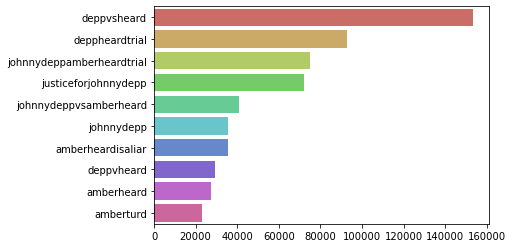

In [27]:
sns.color_palette("Set2")
all_plot = sns.barplot(x=freqdistPlotHash.values, y=freqdistPlotHash.index, palette = 'hls')

Salvo il df

In [28]:
df.to_csv('../data_collection/data/df_clean.csv')

---

# 2. PREPARAZIONE DATASET COMMUNITIES  <a id = 'df_coms'> </a>

Isolo dal dateset le comunità più popolata e unisco queste comunità all'utente (contenuto nel df iniziale)

In [29]:
df

,date,user_id,username,name,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,reply_to,Unnamed: 0.1,token,n_frasi,n_parole_uniche,n_lettere,n_media_parole,word_f
0,2022-04-13,243256585,injdwestan,🌸🦋 Iola 🦋🌸,hi non deppvsheard follower going long week pr...,[],9,0,17,,[],NaN,"[hi, non, deppvsheard, follower, going, long, ...",1,18,108,4.736842,None
1,2022-04-13,986298500328681473,robertaglasspod,Roberta Glass True Crime Report,listening elaine bredehoft excellent opening s...,[],3,2,17,johnnydepp deppvsheard,[],NaN,"[listening, elaine, bredehoft, excellent, open...",1,24,183,6.076923,elaine
2,2022-04-13,3041763071,raidersmera,😈🖤Ares' weapon☠🖤,decide sleep trial sister give testimony,[],1,1,21,deppvsheard,[],NaN,"[decide, sleep, trial, sister, give, testimony]",1,6,40,5.833333,None
3,2022-04-13,1338906226403500032,dalia81213973,Dalia مصر 🇪🇬,cathyrusson lawcrimenetwork case johnny drug w...,[],1,0,11,deppvsheard,"[{'screen_name': 'cathyrusson', 'name': 'Cathy...",NaN,"[cathyrusson, lawcrimenetwork, case, johnny, d...",1,11,88,7.090909,johnny
4,2022-04-12,1217216363409936384,master2020the,Գրեգորի Zebulun 🇦🇲🏴󠁧󠁢󠁷󠁬󠁳󠁿🇯🇲,watching trial see getting fixated similar way...,[],0,0,0,deppvsheard oj teamdepp,[],NaN,"[watching, trial, see, getting, fixated, simil...",1,9,59,5.666667,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271347,2022-06-13,21310247,charlestonsc294,CharlestonSC,bucksexton support red flag hearing ex parte e...,[],1,0,1,,"[{'screen_name': 'BuckSexton', 'name': 'Buck S...",3520.0,"[bucksexton, support, red, flag, hearing, ex, ...",1,19,163,5.307692,None
271348,2022-06-13,3422968041,dparks1000,DParks,autumnonvenus recently watched youtube video s...,[],2,0,7,,"[{'screen_name': 'AutumnOnVenus', 'name': 'Ell...",3521.0,"[autumnonvenus, recently, watched, youtube, vi...",1,19,143,5.545455,None
271349,2022-06-13,1582077440,coastingalong49,CoastingAlong,jesselynradack go trial better televised day e...,[],2,0,0,,"[{'screen_name': 'JesselynRadack', 'name': 'un...",3522.0,"[jesselynradack, go, trial, better, televised,...",1,19,127,5.400000,None
271350,2022-06-13,1072162127920664577,smartaf_,$,time taranaburke wait watch depp heard trial e...,[],1,0,15,,"[{'screen_name': 'TIME', 'name': 'TIME', 'id':...",3523.0,"[time, taranaburke, wait, watch, depp, heard, ...",1,9,59,5.666667,None


## Louvain

In [30]:
coms_lou = pd.read_csv('../data_collection/data/comunità/coms_louvain.csv', low_memory=False)
del coms_lou['Unnamed: 0']
coms_lou

,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,...,community_2452,community_2453,community_2454,community_2455,community_2456,community_2457,community_2458,community_2459,community_2460,community_2461
0,simplyslj,decquine,realamberheard,jwl2nd,faisorler,elonmusk,GellertDepp,itsraining2,stirgussa,SchizoSkits,...,mr_bet01,mybizandlife,thetalentguru,z2htv,socialrobbers,stoptechy1,aylinaydindal,averagebeing99,lekucciglobal,faceswaponline
1,theemilydbaker,deppheardtruth,lisasays_9,chanleycourttv,jossytweets,malinlovesshx,1800imnosey,heavy69342238,__towanda,robert__leonard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,legalbytesmedia,aronberg,briajasminelynn,courttv,Bunmicheshire,fearfully_madee,queenoflockdown,nypost,Eve_Barlow,martinsrosie,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tobiastheginger,ixchelroy,knuthaugen6,adrferg,DrProudman,cherienbenni,Bee75Mo,witch_natural,alargue4rfc,bnopeace69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,thatumbrella,guymrdth,texasmagnolia2,juliecourttv,mensurvivetoo,ghostinkiss,CuteCrook,Newsweek,finwinston,DaaniMonday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,Clementhillsong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1464,JackieG4111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1465,csmcdncr99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1466,inkedonculture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
coms_lou.fillna(value='0', inplace=True)
coms_lou


,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,...,community_2452,community_2453,community_2454,community_2455,community_2456,community_2457,community_2458,community_2459,community_2460,community_2461
0,simplyslj,decquine,realamberheard,jwl2nd,faisorler,elonmusk,GellertDepp,itsraining2,stirgussa,SchizoSkits,...,mr_bet01,mybizandlife,thetalentguru,z2htv,socialrobbers,stoptechy1,aylinaydindal,averagebeing99,lekucciglobal,faceswaponline
1,theemilydbaker,deppheardtruth,lisasays_9,chanleycourttv,jossytweets,malinlovesshx,1800imnosey,heavy69342238,__towanda,robert__leonard,...,0,0,0,0,0,0,0,0,0,0
2,legalbytesmedia,aronberg,briajasminelynn,courttv,Bunmicheshire,fearfully_madee,queenoflockdown,nypost,Eve_Barlow,martinsrosie,...,0,0,0,0,0,0,0,0,0,0
3,tobiastheginger,ixchelroy,knuthaugen6,adrferg,DrProudman,cherienbenni,Bee75Mo,witch_natural,alargue4rfc,bnopeace69,...,0,0,0,0,0,0,0,0,0,0
4,thatumbrella,guymrdth,texasmagnolia2,juliecourttv,mensurvivetoo,ghostinkiss,CuteCrook,Newsweek,finwinston,DaaniMonday,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,Clementhillsong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1464,JackieG4111,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1465,csmcdncr99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1466,inkedonculture,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
coms_lou = coms_lou[['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'community_5', 'community_6', 'community_7', 'community_8', 'community_9', 'community_10']].copy()
coms_lou

,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,community_10
0,simplyslj,decquine,realamberheard,jwl2nd,faisorler,elonmusk,GellertDepp,itsraining2,stirgussa,SchizoSkits,cc_fiji
1,theemilydbaker,deppheardtruth,lisasays_9,chanleycourttv,jossytweets,malinlovesshx,1800imnosey,heavy69342238,__towanda,robert__leonard,amentih_
2,legalbytesmedia,aronberg,briajasminelynn,courttv,Bunmicheshire,fearfully_madee,queenoflockdown,nypost,Eve_Barlow,martinsrosie,voguemagazine
3,tobiastheginger,ixchelroy,knuthaugen6,adrferg,DrProudman,cherienbenni,Bee75Mo,witch_natural,alargue4rfc,bnopeace69,topfactschecker
4,thatumbrella,guymrdth,texasmagnolia2,juliecourttv,mensurvivetoo,ghostinkiss,CuteCrook,Newsweek,finwinston,DaaniMonday,Raven__Smith
...,...,...,...,...,...,...,...,...,...,...,...
1463,Clementhillsong,0,0,0,0,0,0,0,0,0,0
1464,JackieG4111,0,0,0,0,0,0,0,0,0,0
1465,csmcdncr99,0,0,0,0,0,0,0,0,0,0
1466,inkedonculture,0,0,0,0,0,0,0,0,0,0


In [33]:
print ('Numero utenti nella communità 0:', len(coms_lou[coms_lou['community_0'] != '0']))
print ('Numero utenti nella communità 1:', len(coms_lou[coms_lou['community_1'] != '0']))
print ('Numero utenti nella communità 2:', len(coms_lou[coms_lou['community_2'] != '0']))
print ('Numero utenti nella communità 3:', len(coms_lou[coms_lou['community_3'] != '0']))

Numero utenti nella communità 0: 1468
Numero utenti nella communità 1: 948
Numero utenti nella communità 2: 732
Numero utenti nella communità 3: 654


### Creazione dataset con utenti

### Comunità 0

In [34]:
lista_coms = list(coms_lou['community_0'])
len(lista_coms)

1468

In [35]:
filt_df = df[df.username.isin(lista_coms)]

In [36]:
filt_df.shape

(28532, 18)

In [37]:
len(filt_df['username'])

28532

In [38]:
filt_df.to_csv('../data_collection/data/df_coms_lou_0.csv')

---

### Comunità 1

In [39]:
lista_coms_1 = list(coms_lou['community_1'])
len(lista_coms_1)

1468

In [40]:
filt_df_1 = df[df.username.isin(lista_coms_1)]

In [41]:
filt_df_1.shape

(6156, 18)

In [42]:
filt_df_1.to_csv('../data_collection/data/df_coms_lou_1.csv')

---

### Comunità 2

In [43]:
lista_coms_2 = list(coms_lou['community_2'])
len(lista_coms)

1468

In [44]:
filt_df_2 = df[df.username.isin(lista_coms_2)]
filt_df_2.shape

(9831, 18)

In [45]:
filt_df_2.to_csv('../data_collection/data/df_coms_lou_2.csv')

---

### Comunità 3

In [46]:
lista_coms_3 = list(coms_lou['community_3'])
len(lista_coms_3)

1468

In [47]:
filt_df_3 = df[df.username.isin(lista_coms_3)]
filt_df_3.shape

(5579, 18)

In [48]:
filt_df_3.to_csv('../data_collection/data/df_coms_lou_3.csv')

----

# KCLIQUE

In [49]:
coms_kc = pd.read_csv('../data_collection/data/comunità/coms_kc.csv', low_memory=False)
del coms_kc['Unnamed: 0']
coms_kc

,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,...,community_80,community_81,community_82,community_83,community_84,community_85,community_86,community_87,community_88,community_89
0,shanbamanana,Angenette5,brijh,elonmusk,canada316,Cerebus79,traceybaby,nataliesonya,beyondthebench1,Lons,...,realannaowens,esneet4113,227thomas,TheEmilyDBaker,putneyswope9,michaelglflood,abc,rekietalaw,misstruthadare,joflohoosier
1,heatherventures,allezupyourass,ChrissysBlog,justagirl043,robert__leonard,b_sistah,colonelkurtz99,Ihaveadream0101,knackbags,haggisreflux,...,DaniMet1,ssolorio77,j3lte,keep_itt_movinn,theview,julie_sweet_,sadittymommy,awesomismmom,martinsrosie,claracluck33
2,scryndi,hlntv,farrisflagg,barbaraem77,nan4bsb,Raven__Smith,laurieleannie,trotdarrow,nickwriteswords,ljsandahl,...,whosgunnadoit,kyduiguy,kyduiguy,toothfairylala,danabrams,newscomauhq,ca_divorce,hunleyeric,Sibilla08726941,DrProudman
3,asl4nrawkz,wiseaudra,iamprettypetty,tallie_anne,malik_eva,truthfairyland,aburkhartlaw,ihaveadream0101,etbnetwork,raccoonclubhous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,source411,castanzageorgie,CLady62,warriorxqueeng,DrProudman,babetterthanmee,tericarson,deppheardtrial,nmorgasenradio,mandoq3r0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,lorraine_hickey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,marsupial_gamer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,channerz_maiden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,voguemagazine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
coms_kc.fillna(value='0', inplace=True)
coms_kc


,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,...,community_80,community_81,community_82,community_83,community_84,community_85,community_86,community_87,community_88,community_89
0,shanbamanana,Angenette5,brijh,elonmusk,canada316,Cerebus79,traceybaby,nataliesonya,beyondthebench1,Lons,...,realannaowens,esneet4113,227thomas,TheEmilyDBaker,putneyswope9,michaelglflood,abc,rekietalaw,misstruthadare,joflohoosier
1,heatherventures,allezupyourass,ChrissysBlog,justagirl043,robert__leonard,b_sistah,colonelkurtz99,Ihaveadream0101,knackbags,haggisreflux,...,DaniMet1,ssolorio77,j3lte,keep_itt_movinn,theview,julie_sweet_,sadittymommy,awesomismmom,martinsrosie,claracluck33
2,scryndi,hlntv,farrisflagg,barbaraem77,nan4bsb,Raven__Smith,laurieleannie,trotdarrow,nickwriteswords,ljsandahl,...,whosgunnadoit,kyduiguy,kyduiguy,toothfairylala,danabrams,newscomauhq,ca_divorce,hunleyeric,Sibilla08726941,DrProudman
3,asl4nrawkz,wiseaudra,iamprettypetty,tallie_anne,malik_eva,truthfairyland,aburkhartlaw,ihaveadream0101,etbnetwork,raccoonclubhous,...,0,0,0,0,0,0,0,0,0,0
4,source411,castanzageorgie,CLady62,warriorxqueeng,DrProudman,babetterthanmee,tericarson,deppheardtrial,nmorgasenradio,mandoq3r0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,lorraine_hickey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250,marsupial_gamer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
251,channerz_maiden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
252,voguemagazine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
coms_kc = coms_kc[['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'community_5', 'community_6', 'community_7', 'community_8', 'community_9', 'community_10']].copy()
coms_kc

,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,community_10
0,shanbamanana,Angenette5,brijh,elonmusk,canada316,Cerebus79,traceybaby,nataliesonya,beyondthebench1,Lons,kalhanr
1,heatherventures,allezupyourass,ChrissysBlog,justagirl043,robert__leonard,b_sistah,colonelkurtz99,Ihaveadream0101,knackbags,haggisreflux,davidkli
2,scryndi,hlntv,farrisflagg,barbaraem77,nan4bsb,Raven__Smith,laurieleannie,trotdarrow,nickwriteswords,ljsandahl,kattenbarge
3,asl4nrawkz,wiseaudra,iamprettypetty,tallie_anne,malik_eva,truthfairyland,aburkhartlaw,ihaveadream0101,etbnetwork,raccoonclubhous,maxvaldes
4,source411,castanzageorgie,CLady62,warriorxqueeng,DrProudman,babetterthanmee,tericarson,deppheardtrial,nmorgasenradio,mandoq3r0,dohamadani
...,...,...,...,...,...,...,...,...,...,...,...
249,lorraine_hickey,0,0,0,0,0,0,0,0,0,0
250,marsupial_gamer,0,0,0,0,0,0,0,0,0,0
251,channerz_maiden,0,0,0,0,0,0,0,0,0,0
252,voguemagazine,0,0,0,0,0,0,0,0,0,0


In [52]:
print ('Numero utenti nella communità 0:', len(coms_kc[coms_kc['community_0'] != '0']))
print ('Numero utenti nella communità 1:', len(coms_kc[coms_kc['community_1'] != '0']))
print ('Numero utenti nella communità 2:', len(coms_kc[coms_kc['community_2'] != '0']))
print ('Numero utenti nella communità 3:', len(coms_kc[coms_kc['community_3'] != '0']))

Numero utenti nella communità 0: 254
Numero utenti nella communità 1: 43
Numero utenti nella communità 2: 16
Numero utenti nella communità 3: 11


### Comunità 0

In [53]:
lista_coms_kc = list(coms_kc['community_0'])
len(lista_coms_kc)

254

In [54]:
filt_df = df[df.username.isin(lista_coms_kc)]

In [55]:
filt_df.shape

(11769, 18)

In [56]:
filt_df.to_csv('../data_collection/data/df_kclique_coms_0.csv')

---

### Comunità 1

In [57]:

lista_coms_kc_1 = list(coms_kc['community_1'])
len(lista_coms_kc_1)

254

In [58]:
filt_df_1 = df[df.username.isin(lista_coms_kc_1)]

In [59]:
filt_df_1.shape

(3375, 18)

In [60]:
filt_df_1.to_csv('../data_collection/data/df_kclique_coms_1.csv')

---

### Comunità 2

In [61]:
lista_coms_kc_2 = list(coms_kc['community_2'])
len(lista_coms_kc_2)

254

In [62]:
filt_df_2 = df[df.username.isin(lista_coms_kc_2)]

In [63]:
filt_df_2.shape

(3, 18)

In [64]:
filt_df_2.to_csv('../data_collection/data/df_kclique_coms_2.csv')

---

### Comunità 3

In [65]:
lista_coms_3 = list(coms_kc['community_3'])
len(lista_coms_3)

254

In [66]:
filt_df_3 = df[df.username.isin(lista_coms_3)]

In [67]:
filt_df_3.shape

(896, 18)

In [68]:
filt_df_3.to_csv('../data_collection/data/df_kclique_coms_3.csv')

---

# LABEL P.

In [69]:
coms_lp = pd.read_csv('../data_collection/data/comunità/coms_lp.csv', low_memory=False)
del coms_lp['Unnamed: 0']
coms_lp

,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,...,community_4712,community_4713,community_4714,community_4715,community_4716,community_4717,community_4718,community_4719,community_4720,community_4721
0,benzai_daegan,soulsenlighten,mar7729,shanbamanana,kayvandej,geestfu,mrs_right_a,hollienemitz,elyse4design,shefsam1,...,thetalentguru,z2htv,socialrobbers,stoptechy1,ex0t1c_markets,aylinaydindal,averagebeing99,lekucciglobal,faceswaponline,icmynft
1,flowender11,big_d_rants,memehoe50,janielacy,jessica41515,louist91ofTPWK,moinshekh,mikepamelap,pannlewis44,lissy7318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,kyliesm29507820,podrandomly,sicgirl1078,daly_anna,demoncreegan,PresidentSweden,barbarajen,rezzachamp,ebikeadvocate,aad_crypto,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,llivv0123,key13673237,deeb_thee,KeiranSouthern,y2hero,LeJutko,1776_2021_0,burgenah,onlylight210,jayday230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,msmelodius,leximi84,mellymellz____,bondjane007,hellsurrey,KimwhittyKim,LillyJane916,kiraeyl,GermainLussier,mrs_gonzalez05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,jdah2022trial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445,foldsxs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,deniseknows1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
447,red___shoes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
coms_lp.fillna(value='0', inplace=True)
coms_lp


,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,...,community_4712,community_4713,community_4714,community_4715,community_4716,community_4717,community_4718,community_4719,community_4720,community_4721
0,benzai_daegan,soulsenlighten,mar7729,shanbamanana,kayvandej,geestfu,mrs_right_a,hollienemitz,elyse4design,shefsam1,...,thetalentguru,z2htv,socialrobbers,stoptechy1,ex0t1c_markets,aylinaydindal,averagebeing99,lekucciglobal,faceswaponline,icmynft
1,flowender11,big_d_rants,memehoe50,janielacy,jessica41515,louist91ofTPWK,moinshekh,mikepamelap,pannlewis44,lissy7318,...,0,0,0,0,0,0,0,0,0,0
2,kyliesm29507820,podrandomly,sicgirl1078,daly_anna,demoncreegan,PresidentSweden,barbarajen,rezzachamp,ebikeadvocate,aad_crypto,...,0,0,0,0,0,0,0,0,0,0
3,llivv0123,key13673237,deeb_thee,KeiranSouthern,y2hero,LeJutko,1776_2021_0,burgenah,onlylight210,jayday230,...,0,0,0,0,0,0,0,0,0,0
4,msmelodius,leximi84,mellymellz____,bondjane007,hellsurrey,KimwhittyKim,LillyJane916,kiraeyl,GermainLussier,mrs_gonzalez05,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,jdah2022trial,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
445,foldsxs,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
446,deniseknows1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
447,red___shoes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
coms_lp = coms_lp[['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'community_5', 'community_6', 'community_7', 'community_8', 'community_9', 'community_10']].copy()
coms_lp

,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,community_10
0,benzai_daegan,soulsenlighten,mar7729,shanbamanana,kayvandej,geestfu,mrs_right_a,hollienemitz,elyse4design,shefsam1,heatherventures
1,flowender11,big_d_rants,memehoe50,janielacy,jessica41515,louist91ofTPWK,moinshekh,mikepamelap,pannlewis44,lissy7318,kdubsmiles
2,kyliesm29507820,podrandomly,sicgirl1078,daly_anna,demoncreegan,PresidentSweden,barbarajen,rezzachamp,ebikeadvocate,aad_crypto,perceptionchek
3,llivv0123,key13673237,deeb_thee,KeiranSouthern,y2hero,LeJutko,1776_2021_0,burgenah,onlylight210,jayday230,jay77947606
4,msmelodius,leximi84,mellymellz____,bondjane007,hellsurrey,KimwhittyKim,LillyJane916,kiraeyl,GermainLussier,mrs_gonzalez05,missconniebb
...,...,...,...,...,...,...,...,...,...,...,...
444,jdah2022trial,0,0,0,0,0,0,0,0,0,0
445,foldsxs,0,0,0,0,0,0,0,0,0,0
446,deniseknows1,0,0,0,0,0,0,0,0,0,0
447,red___shoes,0,0,0,0,0,0,0,0,0,0


In [72]:
print ('Numero utenti nella communità 0:', len(coms_lp[coms_lp['community_0'] != '0']))
print ('Numero utenti nella communità 1:', len(coms_lp[coms_lp['community_1'] != '0']))
print ('Numero utenti nella communità 2:', len(coms_lp[coms_lp['community_2'] != '0']))
print ('Numero utenti nella communità 3:', len(coms_lp[coms_lp['community_3'] != '0']))

Numero utenti nella communità 0: 449
Numero utenti nella communità 1: 393
Numero utenti nella communità 2: 350
Numero utenti nella communità 3: 214


### Comunità 0

In [73]:
lista_coms_lp_0 = list(coms_lp['community_0'])
len(lista_coms_lp_0)

449

In [74]:
filt_df = df[df.username.isin(lista_coms_lp_0)]

In [75]:
filt_df.shape

(10783, 18)

In [76]:
filt_df.to_csv('../data_collection/data/df_lp_coms_0.csv')

---

### Comunità 1

In [77]:
lista_coms_lp_1 = list(coms_lp['community_1'])
len(lista_coms_lp_1)

449

In [78]:
filt_df_1 = df[df.username.isin(lista_coms_lp_1)]

In [79]:
filt_df_1.shape

(3668, 18)

In [80]:
filt_df_1['tweet']

136                                  eve barf load pathetic
138                                          device court 🤐
158                                  eve barf load pathetic
160                                          device court 🤐
325       always loved aburkhartlaw thought conclusion f...
                                ...                        
271113    legal byte taylor lorenz lied smeared depp hea...
271151               depp heard drama next mean via youtube
271160    legal byte taylor lorenz lied smeared depp hea...
271183    another amazing take fox news place ‘the five ...
271186                   depp heard verdict end via youtube
Name: tweet, Length: 3668, dtype: object

In [81]:
filt_df_1.to_csv('../data_collection/data/df_lp_coms_1.csv')

---

### Comunità 2

In [82]:
lista_coms_lp_2 = list(coms_lp['community_2'])
len(lista_coms_lp_2)

449

In [83]:
filt_df_2 = df[df.username.isin(lista_coms_lp_2)]

In [84]:
filt_df_2.shape

(1966, 18)

In [85]:
filt_df_2.to_csv('../data_collection/data/df_lp_coms_2.csv')

---

### Comunità 3

In [86]:
lista_coms_lp_3 = list(coms_lp['community_3'])
len(lista_coms_lp_3)

449

In [87]:
filt_df_3 = df[df.username.isin(lista_coms_lp_3)]

In [88]:
filt_df_3.shape

(1836, 18)

In [89]:
filt_df_3.to_csv('../data_collection/data/df_lp_coms_3.csv')